<div style="text-align: center; font-size: 14pt;"><b>Employee Attrition: Exploratory Data Analysis</b></div>

### Research Question: 
What are the primary factors influencing employee attrition in a company, and how do they contribute to predicting turnover?

### Data Source: 
The IBM HR Analytics Employee Attrition & Performance dataset (fictional, 1470 rows, 35 columns), available on https://ieee-dataport.org/documents/ibm-hr-analytics-employee-attrition-performance. This dataset includes features such as Age, Job Satisfaction, Monthly Income, OverTime, and the binary target variable Attrition (Yes/No strings).

### Techniques Used in Analysis: 
Exploratory Data Analysis (EDA) was conducted using Python libraries like Pandas, Matplotlib, and Seaborn to visualize distributions, correlations, and imbalances:
- `Box Plot`: Distributions of numerical features by Attrition.
- `Bar Chart`: Categorical features countplots by Attrition.
- `Heatmap`: Correlation heatmap for numerical features.
- `Distribution`: Histograms and KDEs for numerical features.
- `Violin Plot`: Distribution of TrainingTimesLastYear across Department, colored by Attrition.

### Results: 
The analysis showed that factors like age, Job Satisfaction, OverTime, and DistanceFromHome are linked to attrition. 

### Read in the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE



In [2]:
# Load the dataset
df = pd.read_csv('data/HR-Employee-Attrition.csv')

In [3]:
print(df.shape)

(1470, 35)


In [4]:
# Explore few rows
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

### Understanding the Data

In [5]:
# Dataset summary
print(df.info())  
print(df.describe()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [6]:
# Understand Features
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [7]:
# Check for missing values
print("\nMissing Values:\n", df.isna().sum().sum()) 


Missing Values:
 0


In [8]:
# Check for duplicates
print("\nDuplicate Rows:", df.duplicated().sum())


Duplicate Rows: 0


In [9]:
# Class distribution (imbalance: ~84% No, 16% Yes)
print("Attrition distribution:\n", df['Attrition'].value_counts(normalize=True))

Attrition distribution:
 Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64


In [10]:
# Drop constant/ID columns (no info gain)
df = df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1)

In [11]:
# Outliers analysis: Use z-score > 3 for numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
z_scores = np.abs((df[num_cols] - df[num_cols].mean()) / df[num_cols].std())
outliers = (z_scores > 3).sum()
print("\nOutliers per Numerical Feature (z-score > 3):\n", outliers[outliers > 0])
# Handle outliers: Cap at 99th percentile for features with many outliers e.g., YearsAtCompany
for col in ['MonthlyIncome', 'YearsAtCompany', 'TotalWorkingYears', 'YearsWithCurrManager']:
    cap = df[col].quantile(0.99)
    df[col] = np.where(df[col] > cap, cap, df[col])
print("\nOutliers capped for selected features.")


Outliers per Numerical Feature (z-score > 3):
 TotalWorkingYears          16
YearsAtCompany             25
YearsInCurrentRole         13
YearsSinceLastPromotion    42
YearsWithCurrManager       14
dtype: int64

Outliers capped for selected features.


### Exploratory Data Analysis

In [12]:
# Understanding Attrition: Create 2 sets of data frame to analyze the number of employees who left and those who stayed.
left_employee_df = df[df['Attrition'] == 'Yes']  
stayed_employee_df = df[df['Attrition'] == 'No'] 

# Print unique values to verify column content (for debugging)
print("Unique Attrition values:", df['Attrition'].unique())

Unique Attrition values: ['Yes' 'No']


In [13]:
# Count the number of employees who stayed and left
print('Total =', len(df))
print('Number of Employees who left =', len(left_employee_df))
print('% of Employees who left =', (len(left_employee_df) / len(df) * 100), '%')

print('Number of Employees who stayed =', len(stayed_employee_df))
print('% of Employees who stayed =', (len(stayed_employee_df) / len(df) * 100), '%')

Total = 1470
Number of Employees who left = 237
% of Employees who left = 16.122448979591837 %
Number of Employees who stayed = 1233
% of Employees who stayed = 83.87755102040816 %


In [14]:
#See the description of each metric for employees who stayed
stayed_employee_df.describe()

Age    DailyRate  DistanceFromHome    Education  \
count  1233.000000  1233.000000       1233.000000  1233.000000   
mean     37.561233   812.504461          8.915653     2.927007   
std       8.888360   403.208379          8.012633     1.027002   
min      18.000000   102.000000          1.000000     1.000000   
25%      31.000000   477.000000          2.000000     2.000000   
50%      36.000000   817.000000          7.000000     3.000000   
75%      43.000000  1176.000000         13.000000     4.000000   
max      60.000000  1499.000000         29.000000     5.000000   

       EnvironmentSatisfaction   HourlyRate  JobInvolvement     JobLevel  \
count              1233.000000  1233.000000     1233.000000  1233.000000   
mean                  2.771290    65.952149        2.770479     2.145985   
std                   1.071132    20.380754        0.692050     1.117933   
min                   1.000000    30.000000        1.000000     1.000000   
25%                   2.000000    48.000000        2.000000     1.000000   
50%                   3.000000    66.000000        3.000000     2.000000   
75%                   4.000000    83.000000        3.000000     3.000000   
max                   4.000000   100.000000        4.000000     5.000000   

       JobSatisfaction  MonthlyIncome  ...  PerformanceRating  \
count      1233.000000    1233.000000  ...        1233.000000   
mean          2.778589    6831.017867  ...           3.153285   
std           1.093277    4813.581956  ...           0.360408   
min           1.000000    1051.000000  ...           3.000000   
25%           2.000000    3211.000000  ...           3.000000   
50%           3.000000    5204.000000  ...           3.000000   
75%           4.000000    8834.000000  ...           3.000000   
max           4.000000   19626.310000  ...           4.000000   

       RelationshipSatisfaction  StockOptionLevel  TotalWorkingYears  \
count               1233.000000       1233.000000        1233.000000   
mean                   2.733982          0.845093          11.849148   
std                    1.071603          0.841985           7.717829   
min                    1.000000          0.000000           0.000000   
25%                    2.000000          0.000000           6.000000   
50%                    3.000000          1.000000          10.000000   
75%                    4.000000          1.000000          16.000000   
max                    4.000000          3.000000          35.000000   

       TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
count            1233.000000      1233.000000     1233.000000   
mean                2.832928         2.781022        7.345499   
std                 1.293585         0.681907        5.996672   
min                 0.000000         1.000000        0.000000   
25%                 2.000000         2.000000        3.000000   
50%                 3.000000         3.000000        6.000000   
75%                 3.000000         3.000000       10.000000   
max                 6.000000         4.000000       31.000000   

       YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
count         1233.000000              1233.000000           1233.000000  
mean             4.484185                 2.234388              4.343066  
std              3.649402                 3.234762              3.519413  
min              0.000000                 0.000000              0.000000  
25%              2.000000                 0.000000              2.000000  
50%              3.000000                 1.000000              3.000000  
75%              7.000000                 3.000000              7.000000  
max             18.000000                15.000000             14.000000  

[8 rows x 23 columns]

In [15]:
#See the description of each metric for employees who left the company
left_employee_df.describe()

Age    DailyRate  DistanceFromHome   Education  \
count  237.000000   237.000000        237.000000  237.000000   
mean    33.607595   750.362869         10.632911    2.839662   
std      9.689350   401.899519          8.452525    1.008244   
min     18.000000   103.000000          1.000000    1.000000   
25%     28.000000   408.000000          3.000000    2.000000   
50%     32.000000   699.000000          9.000000    3.000000   
75%     39.000000  1092.000000         17.000000    4.000000   
max     58.000000  1496.000000         29.000000    5.000000   

       EnvironmentSatisfaction  HourlyRate  JobInvolvement    JobLevel  \
count               237.000000  237.000000      237.000000  237.000000   
mean                  2.464135   65.573840        2.518987    1.637131   
std                   1.169791   20.099958        0.773405    0.940594   
min                   1.000000   31.000000        1.000000    1.000000   
25%                   1.000000   50.000000        2.000000    1.000000   
50%                   3.000000   66.000000        3.000000    1.000000   
75%                   4.000000   84.000000        3.000000    2.000000   
max                   4.000000  100.000000        4.000000    5.000000   

       JobSatisfaction  MonthlyIncome  ...  PerformanceRating  \
count       237.000000     237.000000  ...         237.000000   
mean          2.468354    4785.188270  ...           3.156118   
std           1.118058    3632.345251  ...           0.363735   
min           1.000000    1009.000000  ...           3.000000   
25%           1.000000    2373.000000  ...           3.000000   
50%           3.000000    3202.000000  ...           3.000000   
75%           3.000000    5916.000000  ...           3.000000   
max           4.000000   19626.310000  ...           4.000000   

       RelationshipSatisfaction  StockOptionLevel  TotalWorkingYears  \
count                237.000000        237.000000         237.000000   
mean                   2.599156          0.527426           8.202532   
std                    1.125437          0.856361           6.994028   
min                    1.000000          0.000000           0.000000   
25%                    2.000000          0.000000           3.000000   
50%                    3.000000          0.000000           7.000000   
75%                    4.000000          1.000000          10.000000   
max                    4.000000          3.000000          35.000000   

       TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
count             237.000000       237.000000      237.000000   
mean                2.624473         2.658228        5.080169   
std                 1.254784         0.816453        5.692501   
min                 0.000000         1.000000        0.000000   
25%                 2.000000         2.000000        1.000000   
50%                 2.000000         3.000000        3.000000   
75%                 3.000000         3.000000        7.000000   
max                 6.000000         4.000000       31.000000   

       YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
count          237.000000               237.000000            237.000000  
mean             2.902954                 1.945148              2.852321  
std              3.174827                 3.153077              3.143349  
min              0.000000                 0.000000              0.000000  
25%              0.000000                 0.000000              0.000000  
50%              2.000000                 1.000000              2.000000  
75%              4.000000                 2.000000              5.000000  
max             15.000000                15.000000             14.000000  

[8 rows x 23 columns]

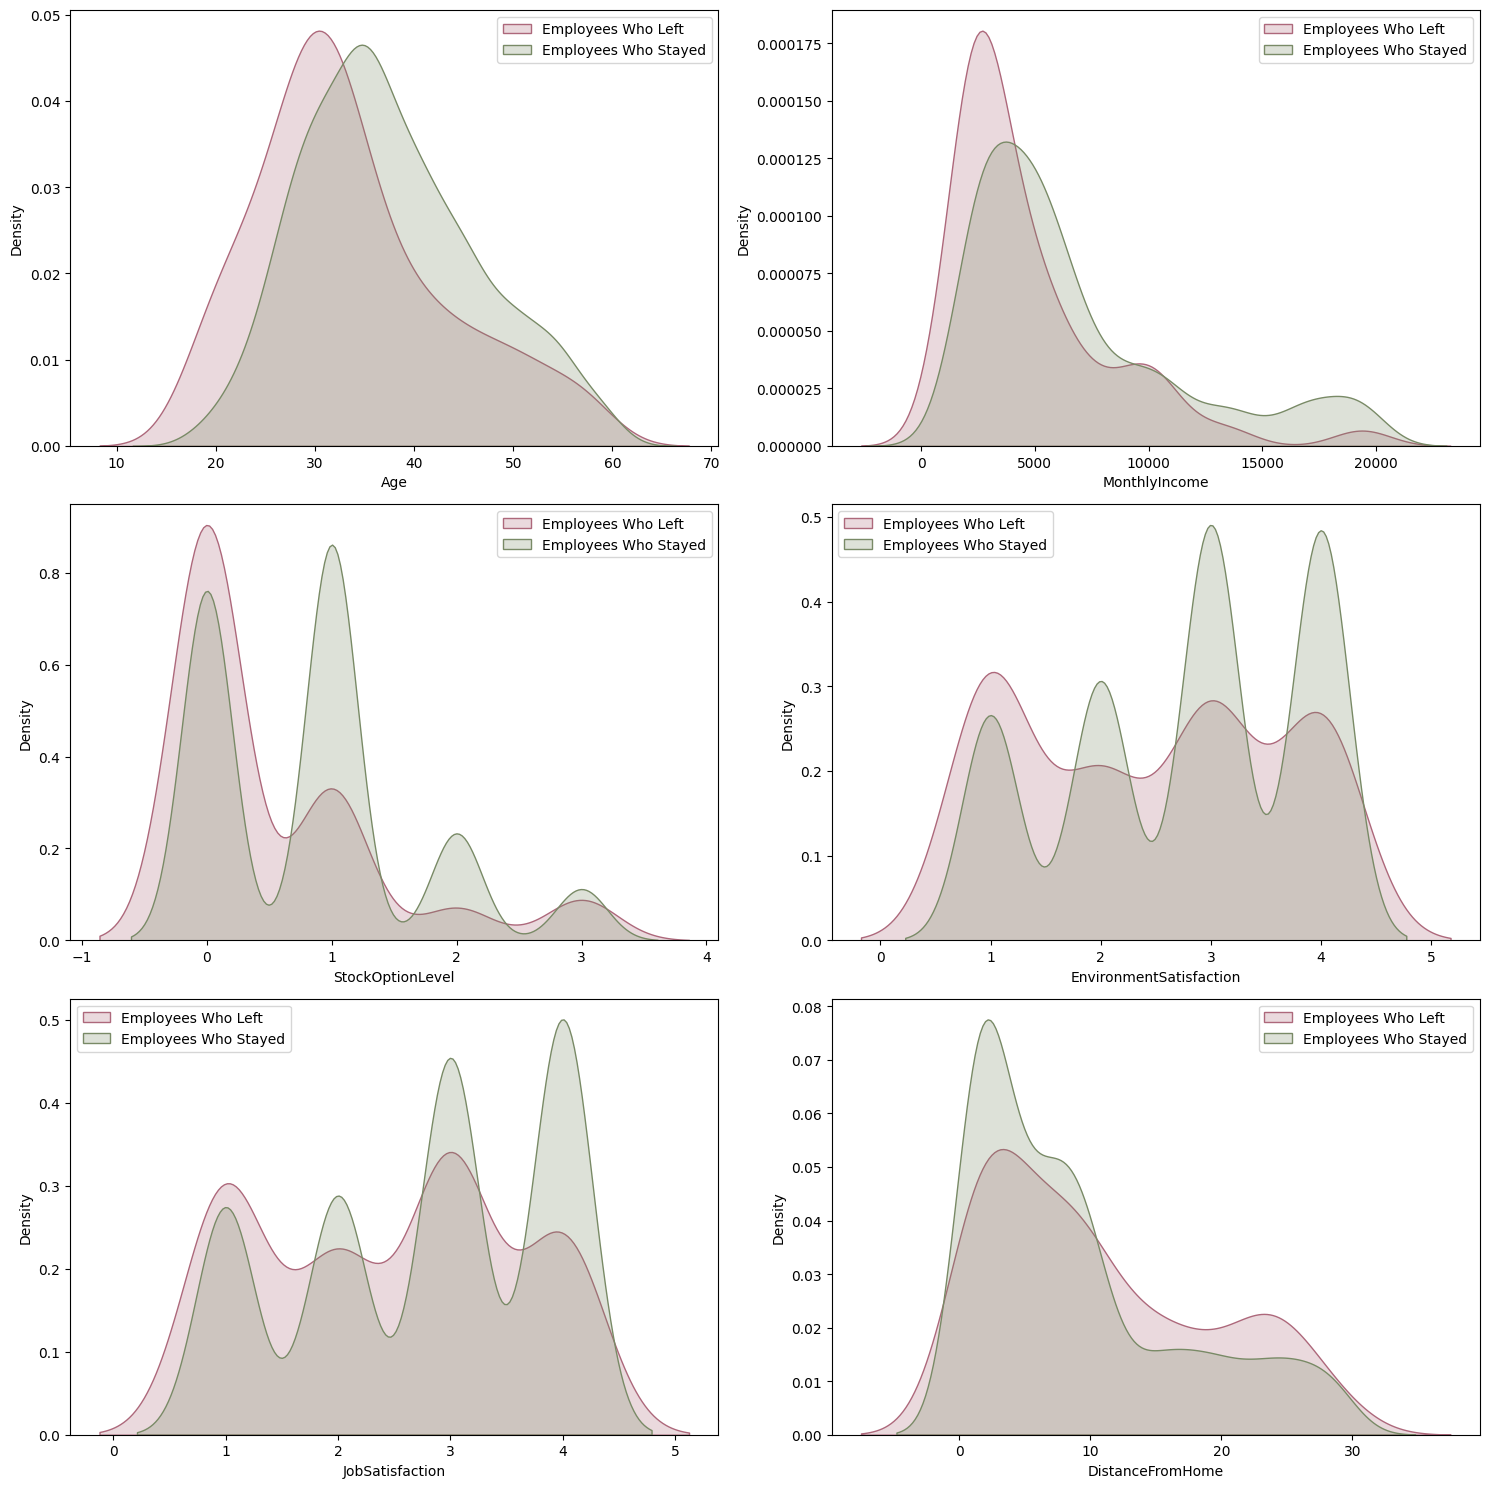

In [16]:
# KDE (Kernel Density Estimate) Plot for Visualising the probable density of Age, MonthlyIncome, StockOptionLevel, EnvironmentSatisfaction, JobSatisfaction, and DistanceFromHome in 2 columns and 3 rows
import matplotlib.pyplot as plt
import seaborn as sns

features = ['Age', 'MonthlyIncome', 'StockOptionLevel', 'EnvironmentSatisfaction', 'JobSatisfaction', 'DistanceFromHome']

fig, axs = plt.subplots(3, 2, figsize=(15, 15))  

axs = axs.flatten()  # Flatten for easy indexing

for i, feature in enumerate(features):
    sns.kdeplot(left_employee_df[feature], label='Employees Who Left', fill=True, color='#AD687B', ax=axs[i])
    sns.kdeplot(stayed_employee_df[feature], label='Employees Who Stayed', fill=True, color='#798A66', ax=axs[i])
    axs[i].legend()  # to show employee stayed and left in chart
    axs[i].set_xlabel(feature)  # plot x axis title
    axs[i].set_ylabel('Density')  # plot y axis title

plt.tight_layout()  # Adjust subplots to fit nicely
plt.savefig('images/KDE.png')  #Save image in folder
plt.show()

### Interpretation:

- `Age as a Factor:` Employees who leave are notably younger (mean age 33.6 vs. 37.6), with a tighter age distribution (lower std). This suggests early-career employees may be more prone to attrition due to factors like job-hopping for better opportunities, lack of long-term commitment, or dissatisfaction with entry-level roles. Retention strategies could target younger workers with mentorship programs or career growth paths.
- `Monthly Income:` Those who leave the company have significantly lower average monthly income (~$4,787 vs. $6,832), with medians showing a similar gap ($3,208 vs. $4,918). This indicates compensation is a strong predictor of turnover—employees may leave for higher-paying jobs elsewhere. The wide income range (high std) for both groups points to variability by role/department, but lower earners are at higher risk. Visualizations like box plots (from EDA) would confirm outliers in high-income leavers, possibly executives seeking new challenges.
- `Stock Option Level:` Employees who stayed have higher stock option levels.
- `Environment Satisfaction:` Employees who stayed are more satisfied with the environment.
- `Job Satisfaction:` Employees who stayed are more satisfied with their job.
- `Other Insights:`
    - Higher distance from home and lower job satisfaction among leavers reinforce work-life balance issues (e.g., commute stress, overtime).
    - Features like TrainingTimesLastYear show minimal differences (median ~3 for both), suggesting training alone isn't a strong retention driver unless targeted (e.g., via violin plots by department).

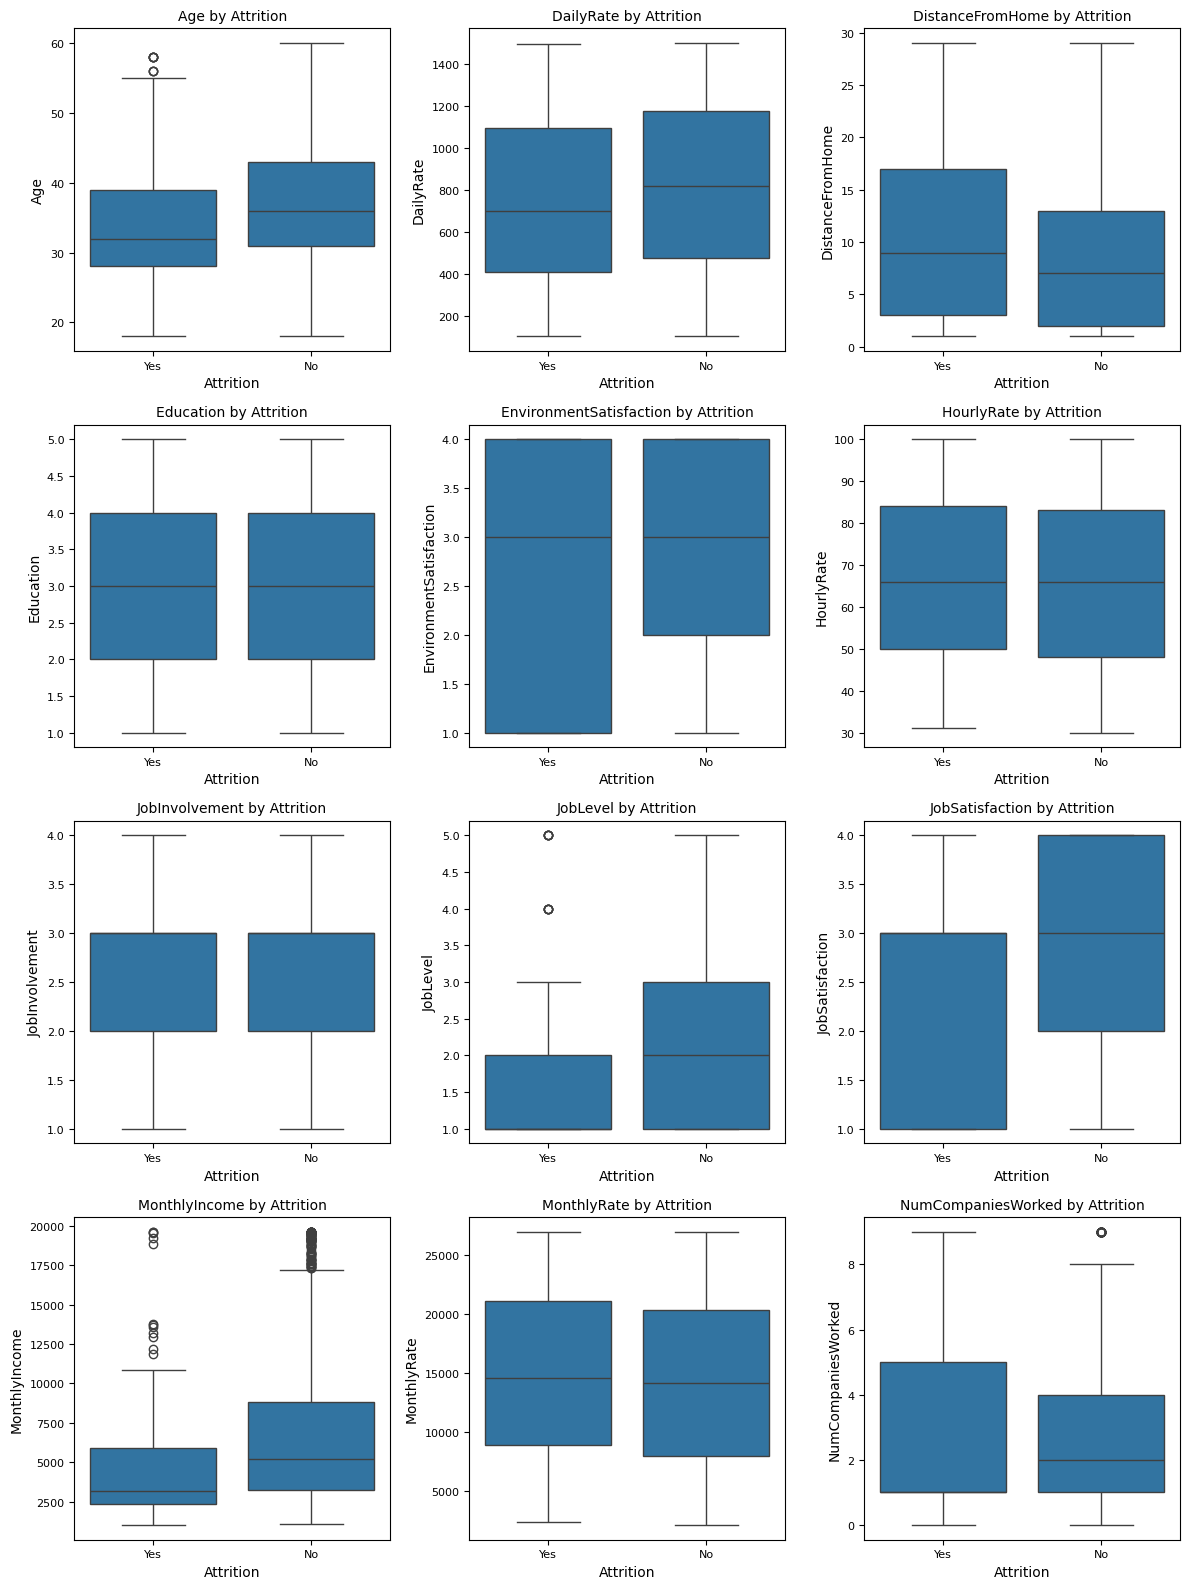

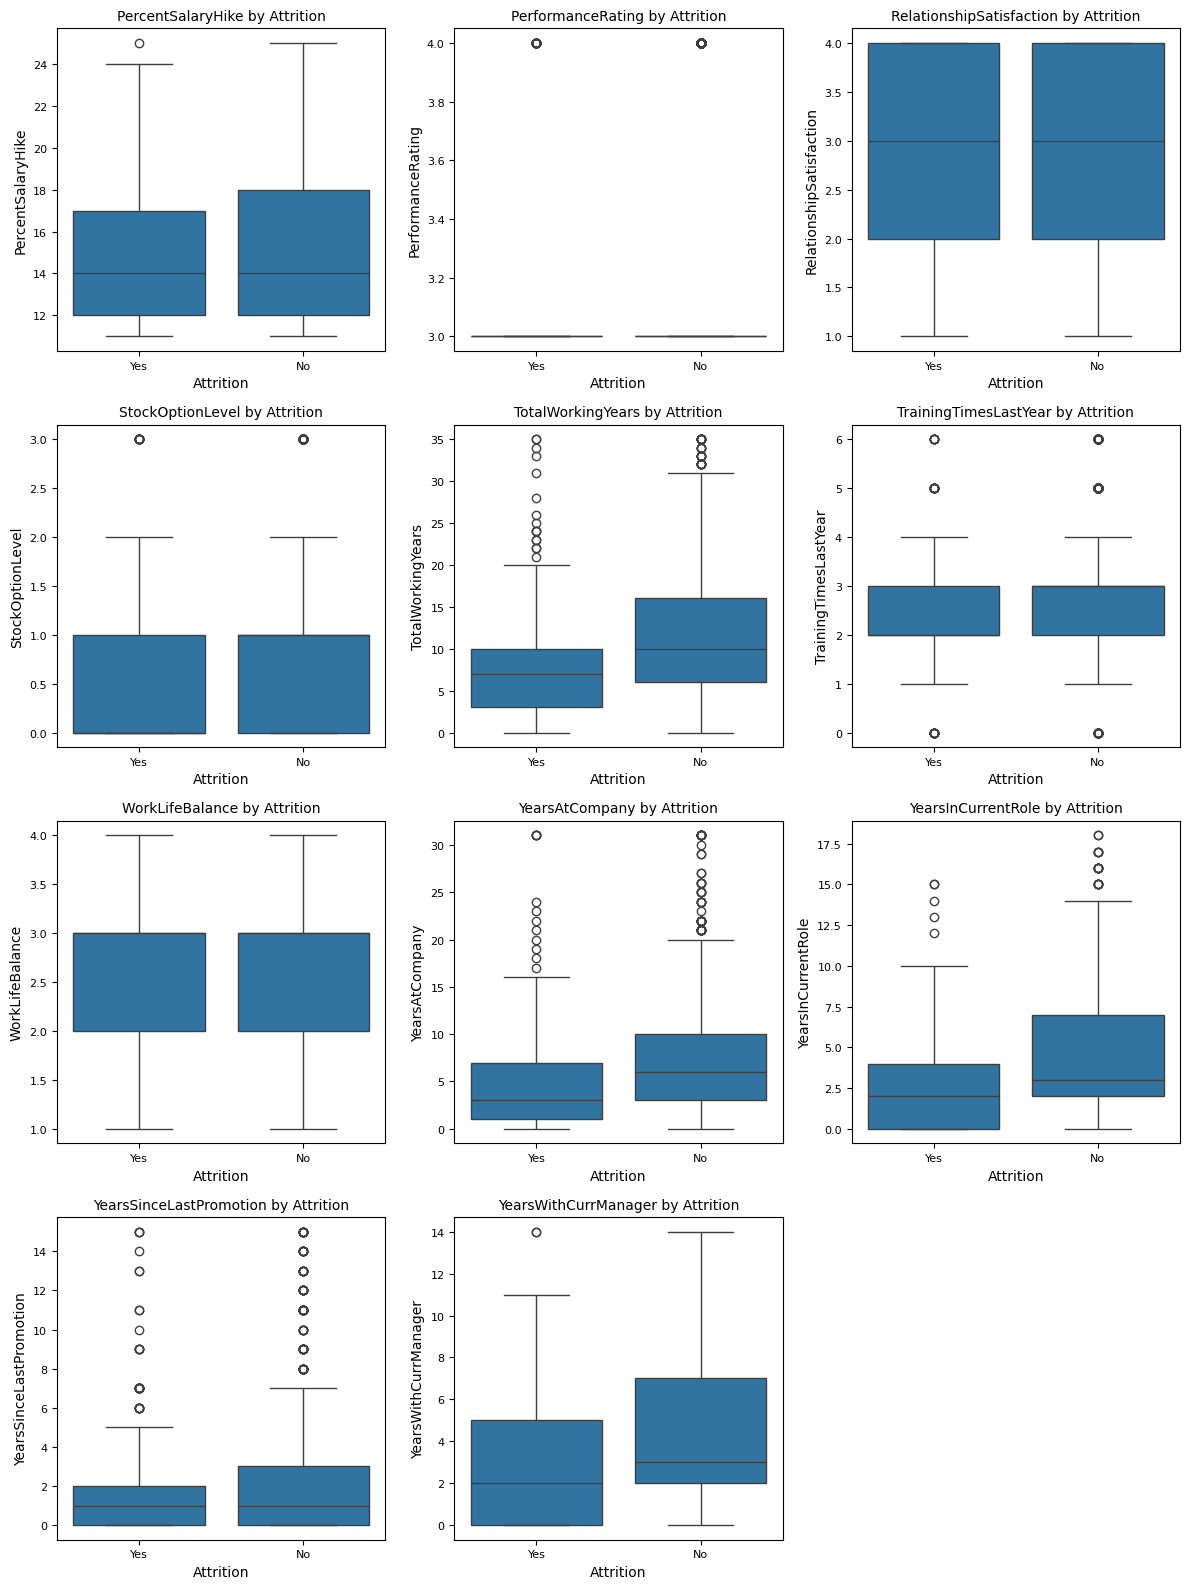

In [17]:
import math
# Numerical features boxplots by Attrition
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_plots = len(num_cols)
cols_per_row = 3
max_rows_per_fig = 4
max_plots_per_fig = max_rows_per_fig * cols_per_row

plot_idx = 0
for fig_num in range(math.ceil(num_plots / max_plots_per_fig)):
    remaining_plots = num_plots - plot_idx
    plots_in_fig = min(remaining_plots, max_plots_per_fig)
    rows_in_fig = math.ceil(plots_in_fig / cols_per_row)
    
    fig, axes = plt.subplots(rows_in_fig, cols_per_row, figsize=(12, 4 * rows_in_fig))  # Adjust height dynamically
    axes = axes.flatten()
    
    for i in range(plots_in_fig):
        col = num_cols[plot_idx]
        sns.boxplot(x='Attrition', y=col, data=df, ax=axes[i])
        axes[i].set_title(f'{col} by Attrition', fontsize=10)
        axes[i].tick_params(labelsize=8)
        plot_idx += 1
    
    # Hide unused axes if any
    for i in range(plots_in_fig, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'images/BoxPlot_{fig_num+1}.png', bbox_inches='tight')  # Save each figure separately to avoid whitespace issues
    plt.show()

### Interpretation:
The boxplots compare distributions of numerical features between employees who left (Attrition: Yes) and stayed (No) in the IBM HR Analytics dataset. Leavers (~16% of data) often show shifted medians, tighter ranges, and more outliers, highlighting turnover risks. Constant features (e.g., EmployeeCount, StandardHours) are uninformative (flat boxes). Key insights grouped below:

#### Demographics & Experience:
- `Age:` Leavers have lower median (~32 vs. ~36) and fewer high outliers, indicating younger employees are more likely to exit.
- `TotalWorkingYears/YearsAtCompany/YearsInCurrentRole:` Lower medians for leavers (~7/3/2 vs. ~10/5/4), with shorter boxes, suggesting short-tenure or less experienced workers churn faster due to limited advancement.
- `NumCompaniesWorked:` Higher median for leavers (~3 vs. ~2), implying job-hoppers are attrition-prone.
- `YearsSinceLastPromotion:` Slightly higher median for leavers (~1.5 vs. ~1), with more outliers, pointing to stagnation as a frustration driver.
- `YearsWithCurrManager:` Lower median for leavers (~2 vs. ~4), highlighting poor manager relationships or recent changes as risks.

#### Compensation & Rewards
- `MonthlyIncome/DailyRate/HourlyRate/MonthlyRate:` Leavers show lower medians (e.g., MonthlyIncome ~$3k vs. ~$5k), tighter IQRs, and fewer high outliers, confirming underpayment drives turnover.
- `PercentSalaryHike:` Slightly higher for leavers (~15% vs. ~14%), possibly due to recent raises failing to retain dissatisfied staff.
- `StockOptionLevel:` Lower median for leavers (0 vs. 1), suggesting lack of equity incentives reduces loyalty.

#### Satisfaction & Engagement
- `JobSatisfaction/EnvironmentSatisfaction/JobInvolvement/RelationshipSatisfaction/WorkLifeBalance:` Consistently lower medians for leavers (e.g., JobSatisfaction ~2 vs. ~3; WorkLifeBalance ~2.5 vs. ~2.8), with downward shifts, underscoring morale and balance as strong predictors of retention.
PerformanceRating: Minimal differences (both ~3.1-3.2), indicating performance alone doesn't prevent attrition.

### Overall Implications: 
Attrition ties to youth, low pay/satisfaction, short tenure, and work-life strains, not performance or education. For prediction, prioritize these in models; HR could target interventions like promotions or remote options to cut ~16% turnover.

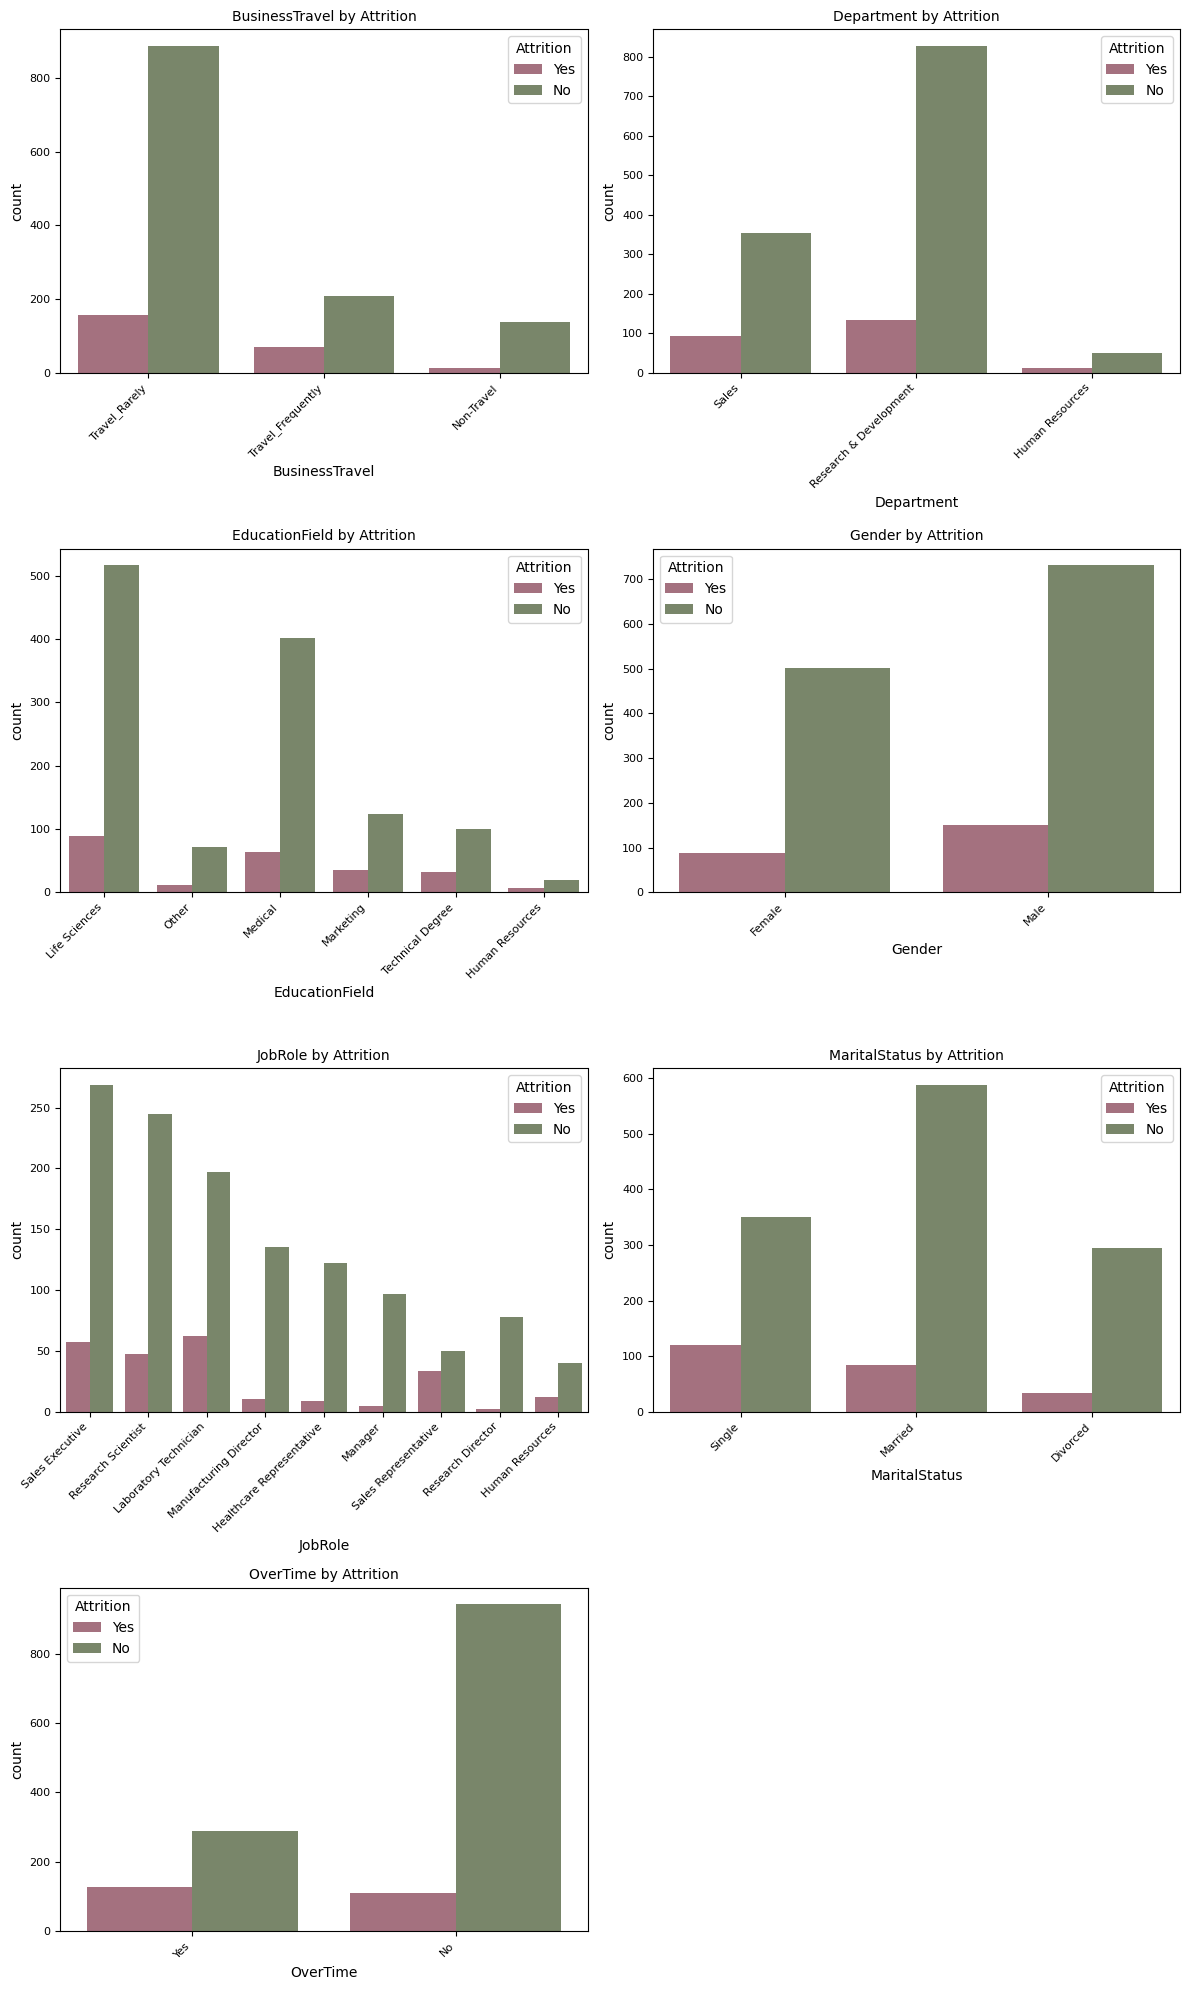

In [18]:
# Categorical features countplots by Attrition
cat_cols = df.select_dtypes(include='object').columns.drop('Attrition')
num_plots = len(cat_cols)
cols_per_row = 2
rows = 4
num_figures = math.ceil(num_plots / (rows * cols_per_row))

plot_idx = 0
for fig_num in range(num_figures):
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(12, 20)) 
    axes = axes.flatten()
    
    for i in range(len(axes)):
        if plot_idx < num_plots:
            col = cat_cols[plot_idx]
            sns.countplot(x=col, hue='Attrition', data=df, ax=axes[i], palette=['#AD687B', '#798A66'])
            axes[i].set_title(f'{col} by Attrition', fontsize=10)
            axes[i].tick_params(labelsize=8)
            
            # Fix warning: Explicitly set ticks before labels
            labels = [label.get_text() for label in axes[i].get_xticklabels()]
            axes[i].set_xticks(range(len(labels)))
            axes[i].set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
            
            plot_idx += 1
        else:
            axes[i].axis('off')  # Hide unused subplots
    
    plt.tight_layout()
    plt.savefig('images/CategoricalFeaturesByAttrition.png')  
    plt.show()

### Interpretation
These bar plots display counts of employees by Attrition across categorical features, revealing disproportionate turnover rates. Retention dominates overall (84%), but certain categories show higher relative attrition (20-30%), aiding prediction of at-risk groups.

#### Travel & Department
- `BusinessTravel:` Frequent travelers have higher attrition (proportional pink bars larger relative to green), suggesting travel fatigue contributes to 25% turnover vs. ~10% for non-travelers.
- `Department:` Sales shows the highest attrition rate (25%), followed by R&D (16%) and HR (20%), indicating sales roles' stress or quotas drive exits.

#### Education & Demographics
- `EducationField:` Life Sciences and Medical dominate the dataset but have moderate attrition (15%); Technical Degree and Marketing show higher relative rates (20-25%), possibly due to competitive job markets.
- `Gender:` Slight male skew in attrition (17% vs. 15% female), but minimal difference, implying gender is a weak predictor.
- `MaritalStatus:` Singles exhibit the highest attrition (25%), vs. ~10% for married/divorced, linking single status (e.g., fewer ties) to mobility.

#### Role & Work Factors

- `JobRole:` High attrition in entry-level roles like Sales Rep (40%), Lab Tech (25%), and Research Scientist (20%), while managers/directors show low rates (5-10%), highlighting junior role dissatisfaction or burnout.
- `OverTime:` Dramatic imbalance—overtime workers have ~30% attrition vs. 10% without, confirming overtime as a strong turnover driver due to work-life imbalance.

### Overall Implications: 
Attrition clusters in high-stress categories (frequent travel, sales roles, overtime, singles), not demographics like gender/education. For modeling, encode these as features in ensembles; HR could mitigate via reduced overtime or role-specific support to lower overall turnover.

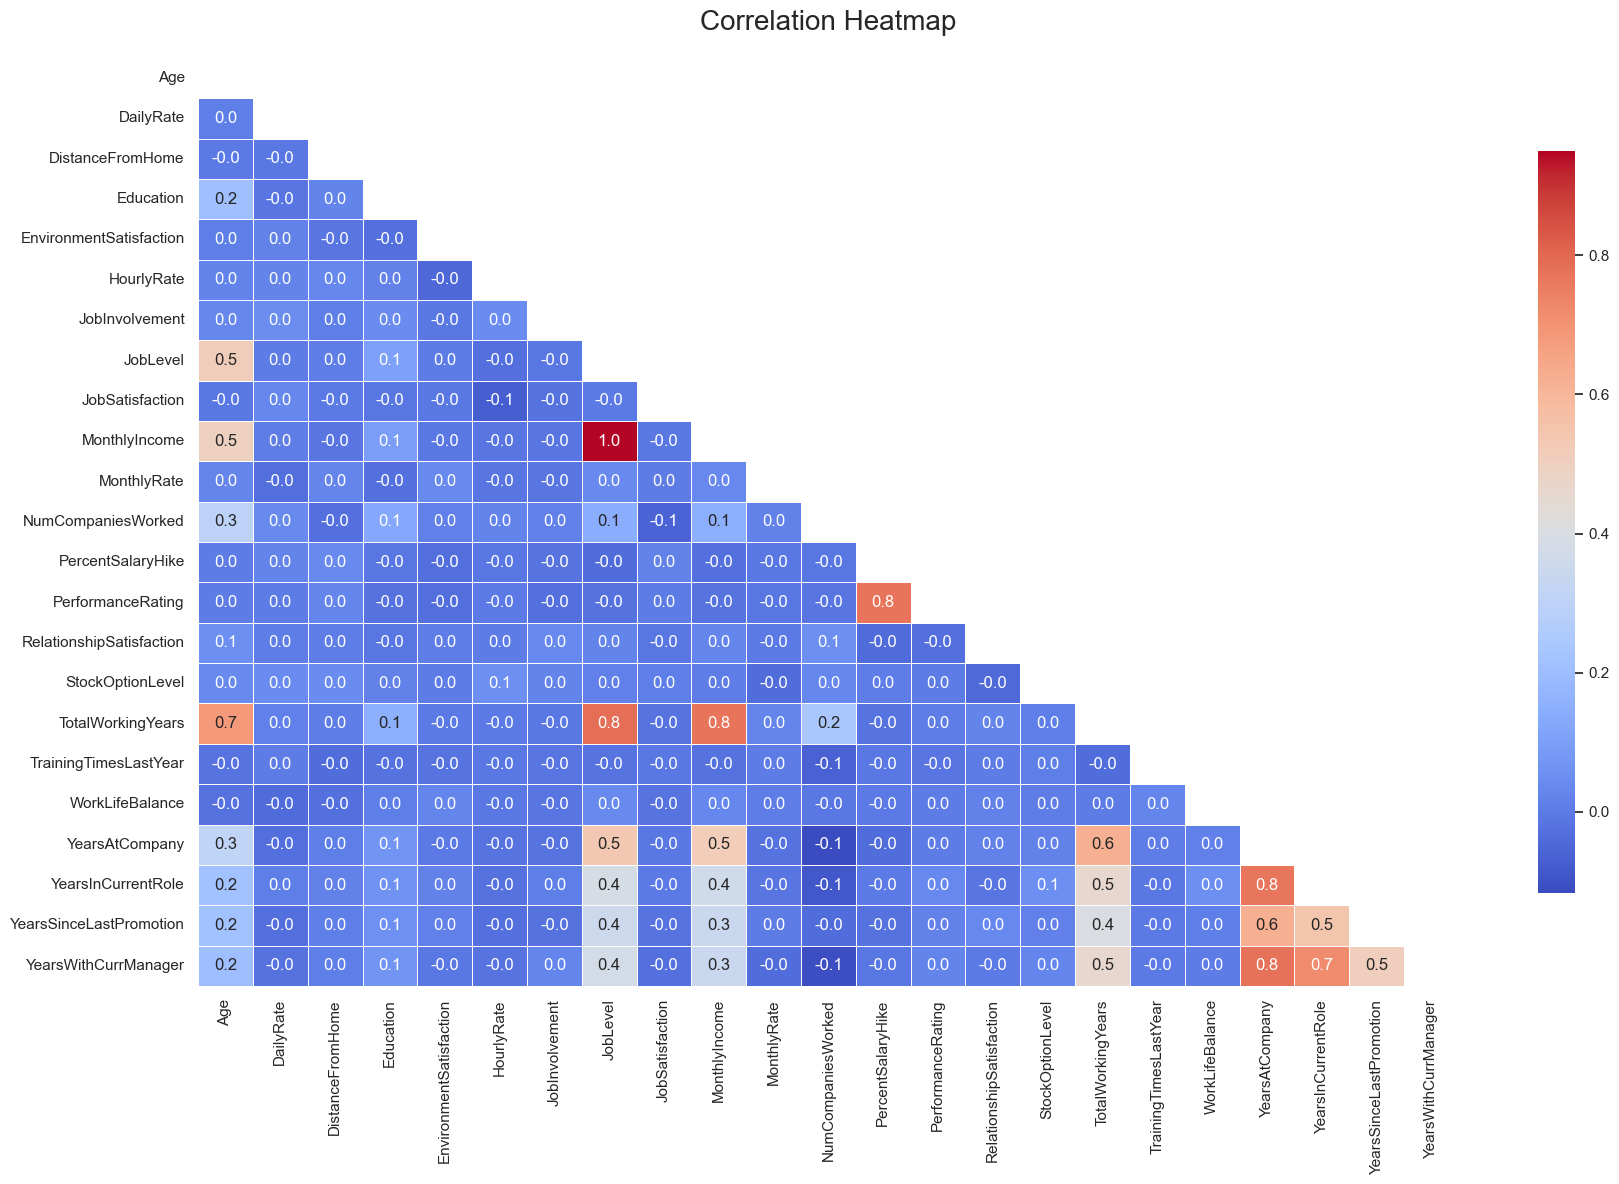

In [19]:
# Correlation heatmap for numerical features
df_numeric = df.select_dtypes(include=np.number)
corr_matrix = df_numeric.corr()

sns.set_theme(style="white")
plt.figure(figsize=(18, 12)) 

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,         
    annot=True,         
    fmt=".1f",          
    cmap='coolwarm',    
    linewidths=.5,     
    cbar_kws={"shrink": .8} 
)


plt.title("Correlation Heatmap", fontsize=20, pad=20)
plt.xticks(rotation=90) 
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('images/Heatmap.png')  
plt.show()

import warnings
warnings.filterwarnings("ignore")

### Interpretation 
This Pearson correlation heatmap for numerical features shows mostly weak relationships (blues near 0), with clusters of moderate-to-strong positive correlations (oranges/reds) among related variables:

- `Experience & Compensation Cluster:` High correlations between JobLevel and MonthlyIncome (0.95), TotalWorkingYears (0.78), and Age (0.5), indicating seniority drives pay and tenure; multicollinearity risk for modeling—consider PCA or feature selection.
- `Tenure Metrics:` Strong links among YearsAtCompany, YearsInCurrentRole (~0.76), YearsWithCurrManager (0.77), and YearsSinceLastPromotion (~0.55), reflecting career progression patterns.
- `Weak/Independent Features:` Low correlations for satisfaction (e.g., JobSatisfaction, WorkLifeBalance 0-0.1 with others) and rates (DailyRate, HourlyRate near 0), suggesting they add unique variance.
No Strong Negatives: Mild negatives (e.g., NumCompaniesWorked and Age -0.3) imply job-hoppers are younger.

### Implications:
Linear models may underperform due to weak ties; use nonlinear methods (e.g., trees) for Attrition prediction. Drop redundants to reduce overfitting.

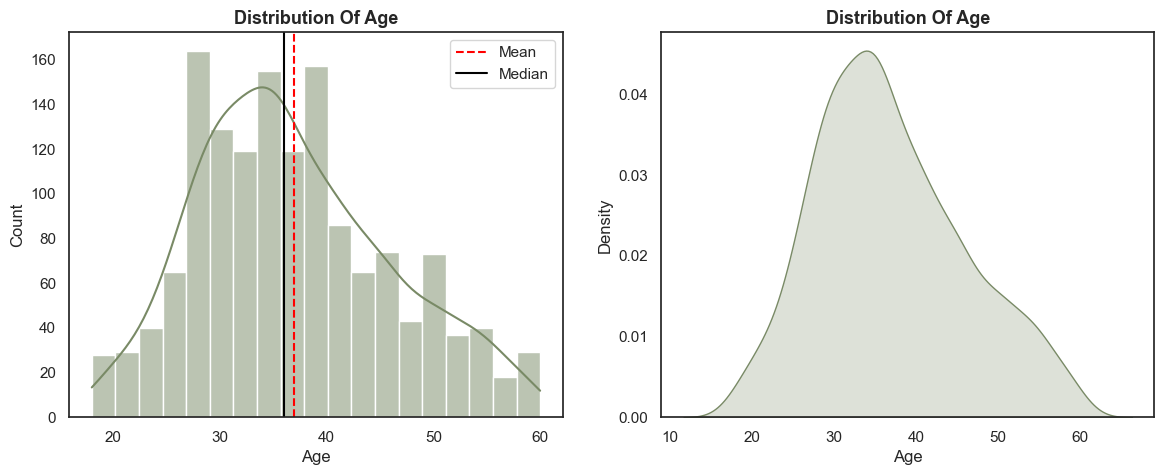

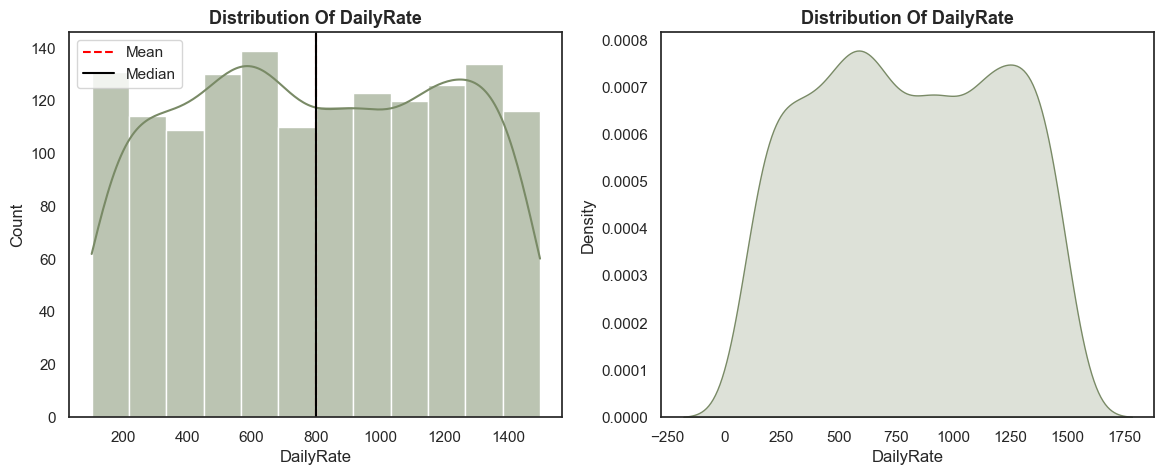

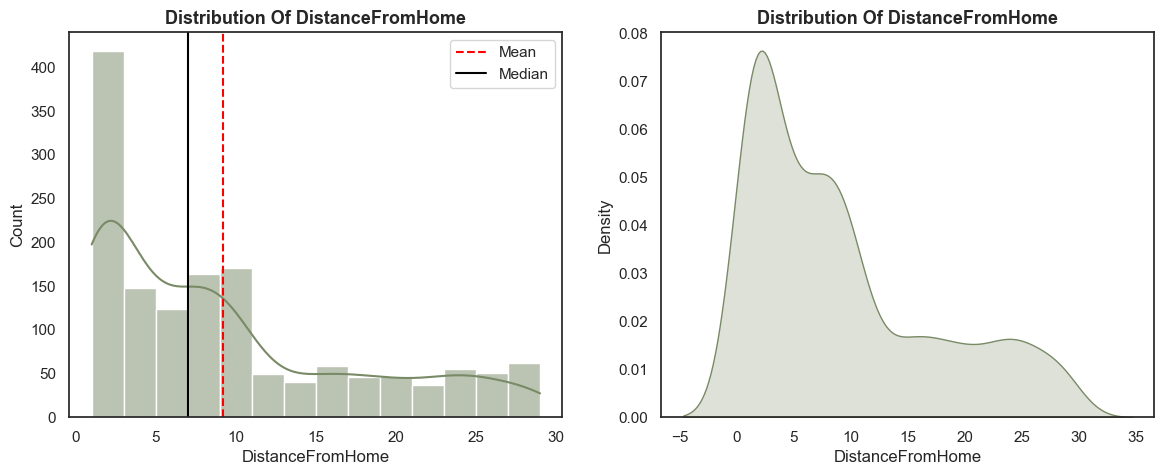

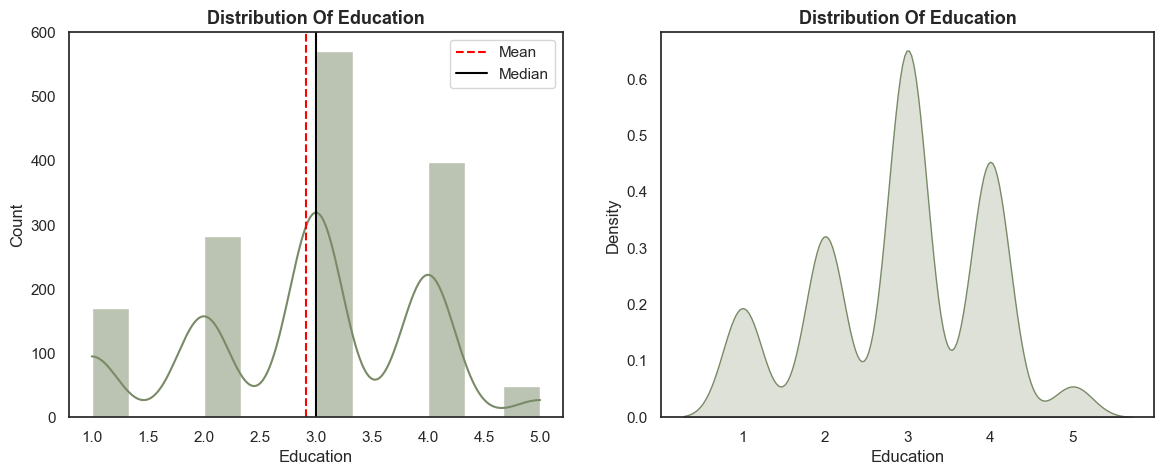

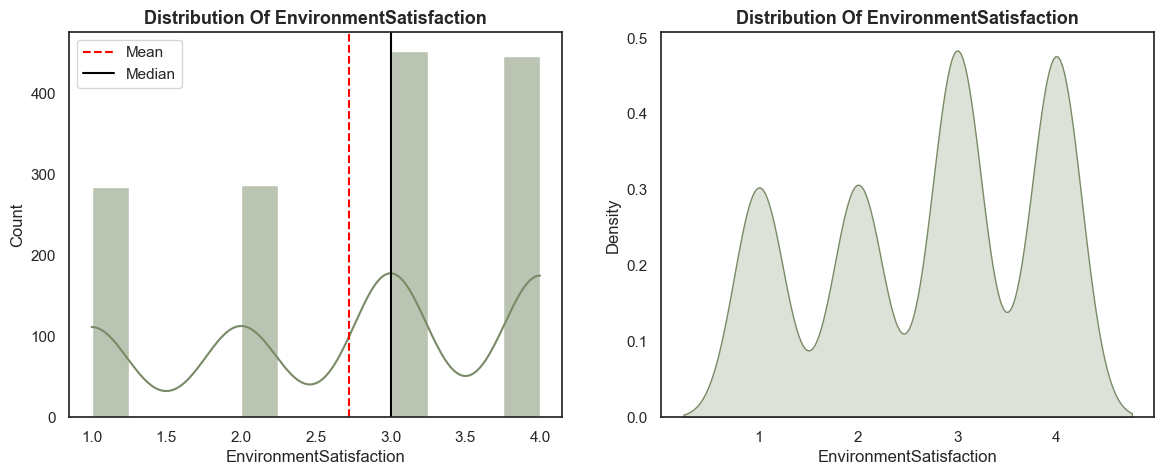

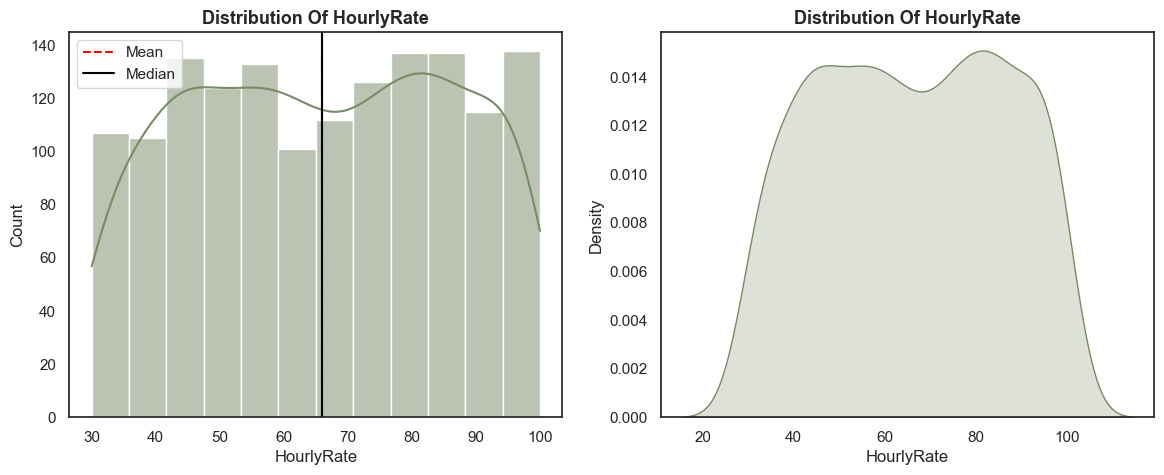

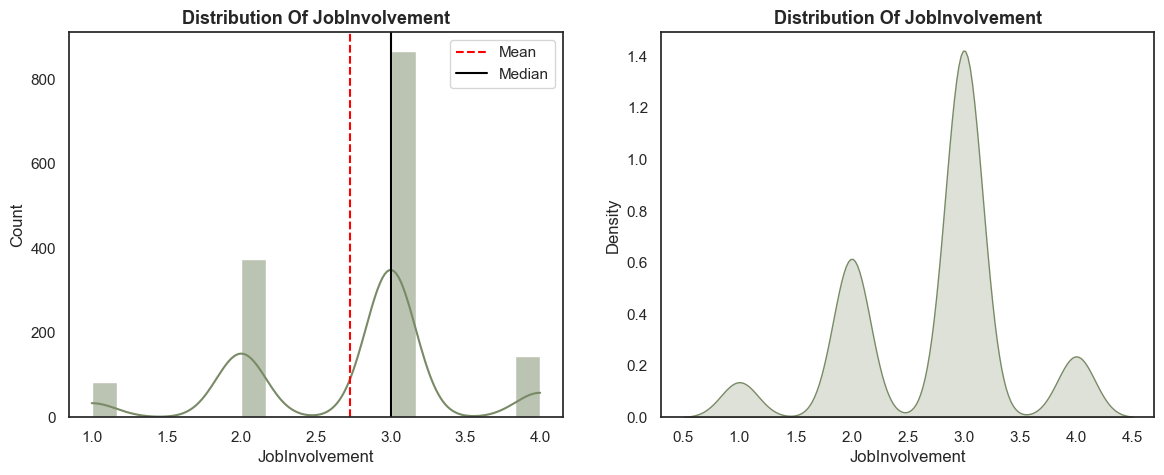

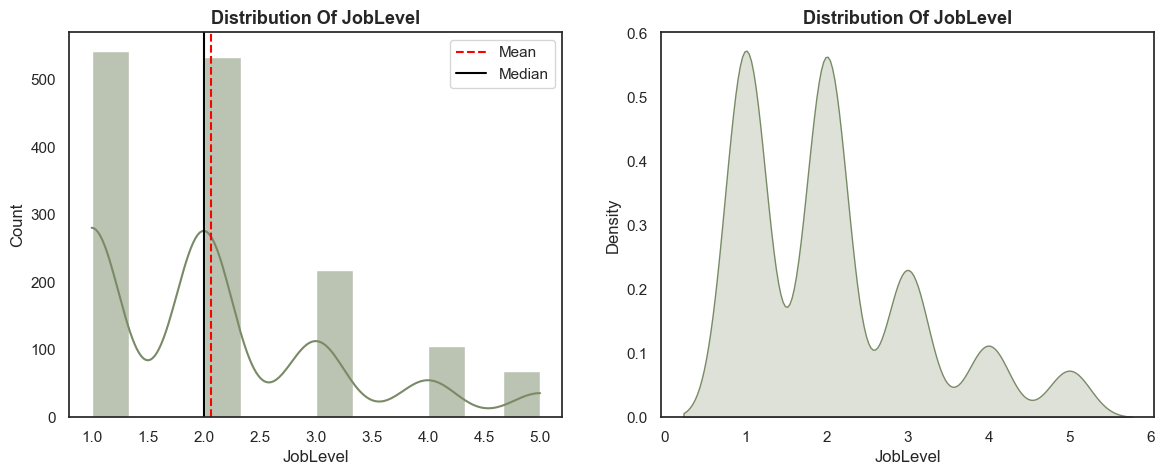

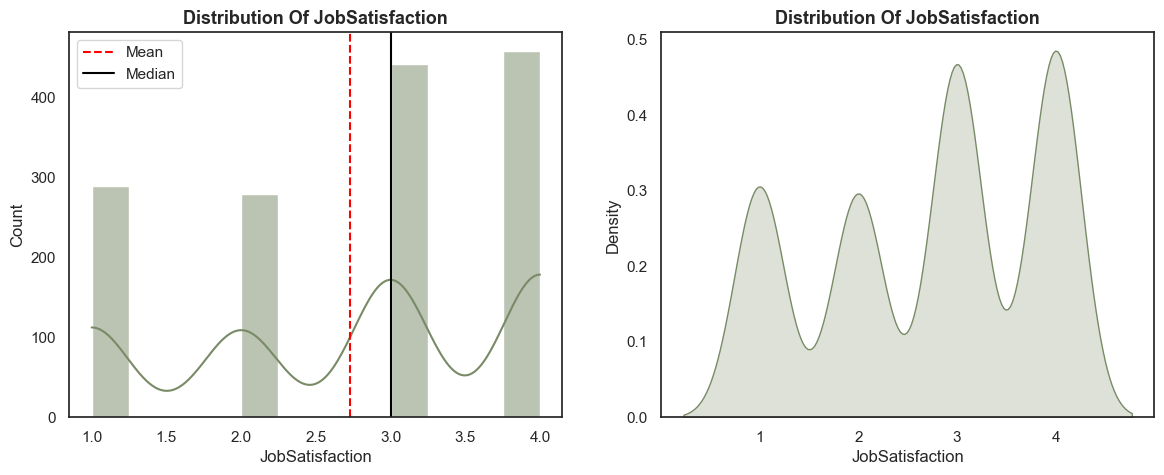

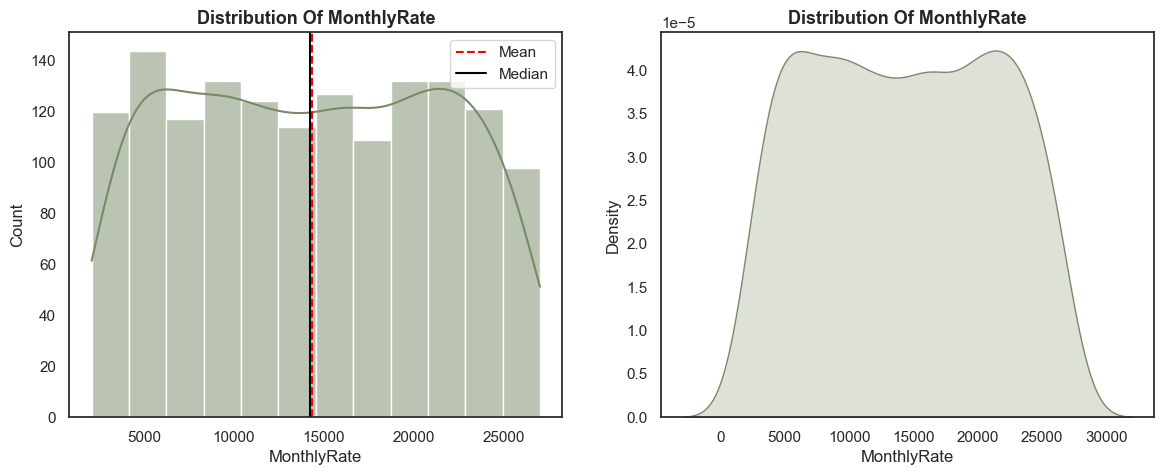

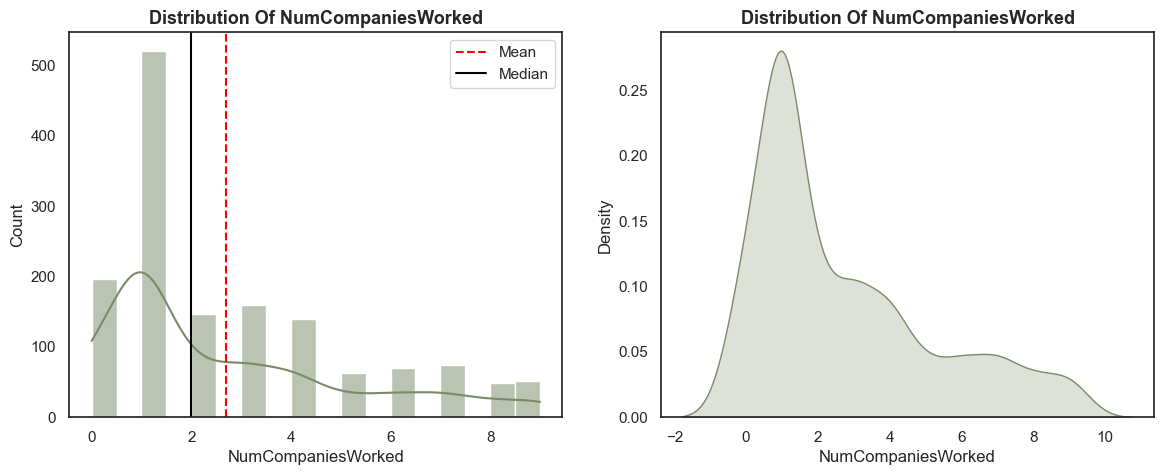

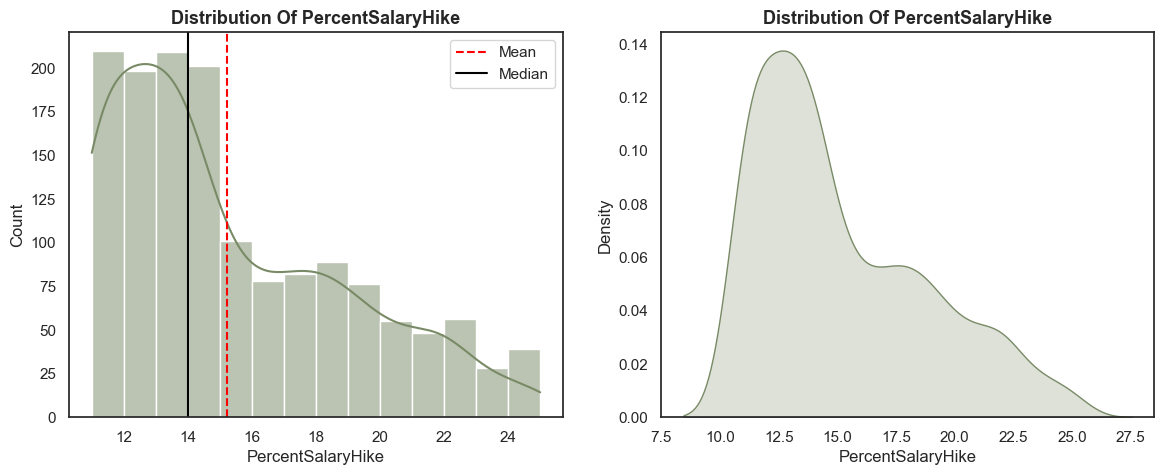

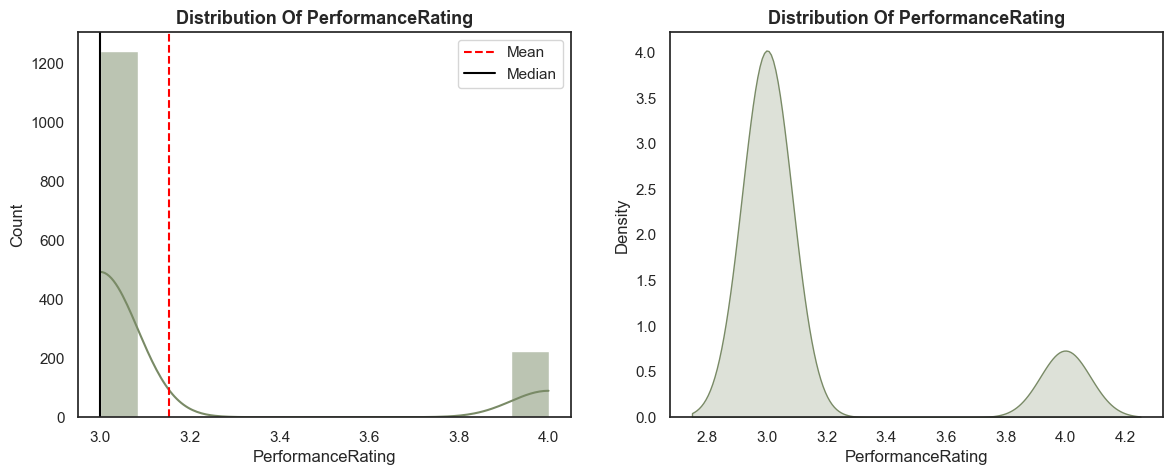

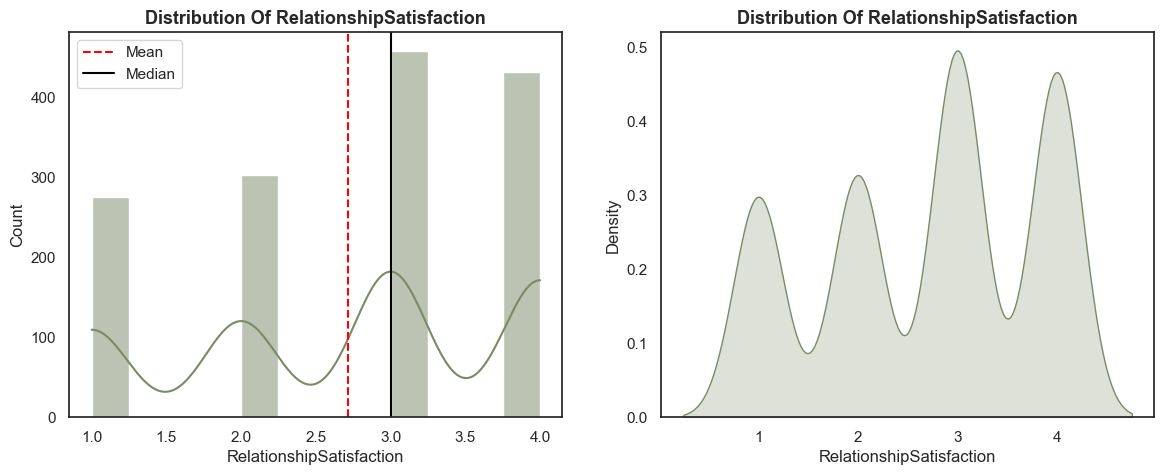

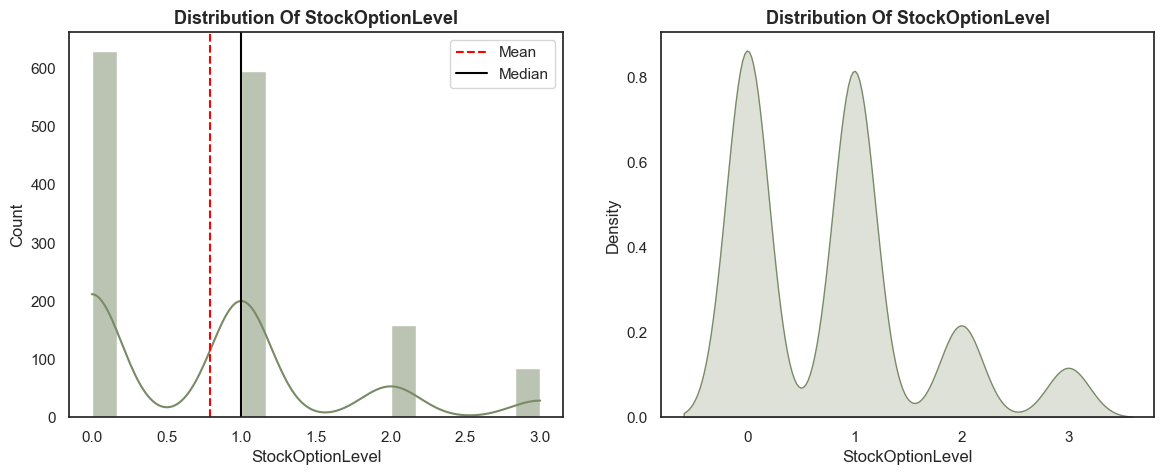

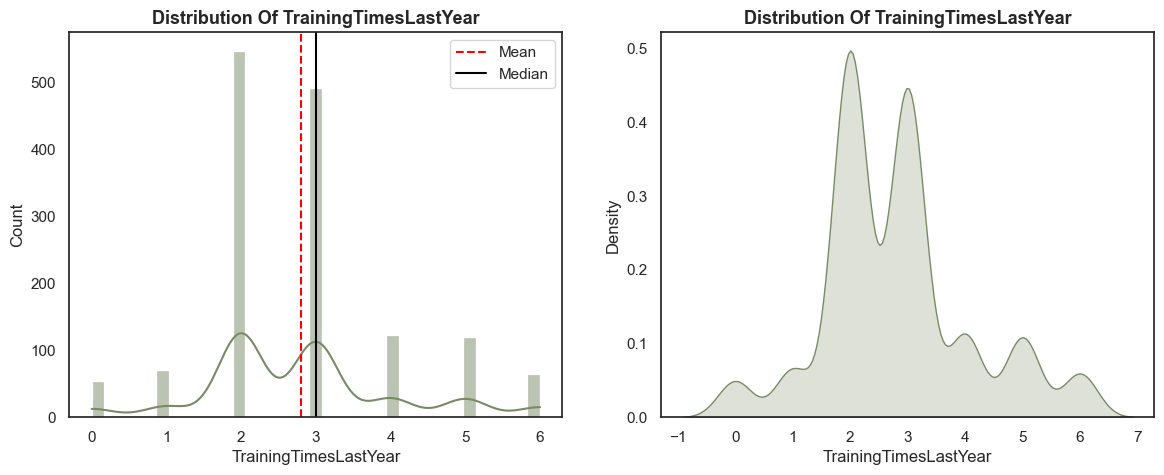

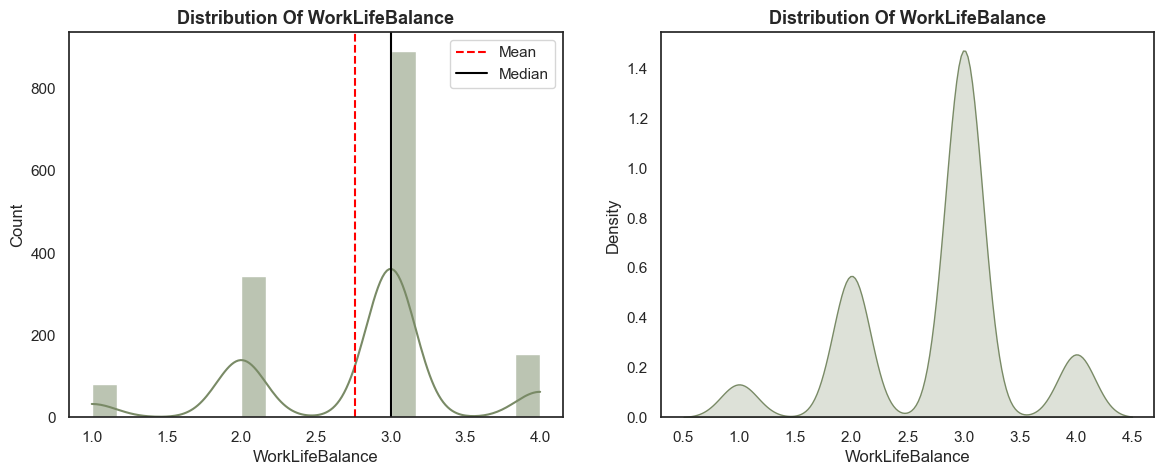

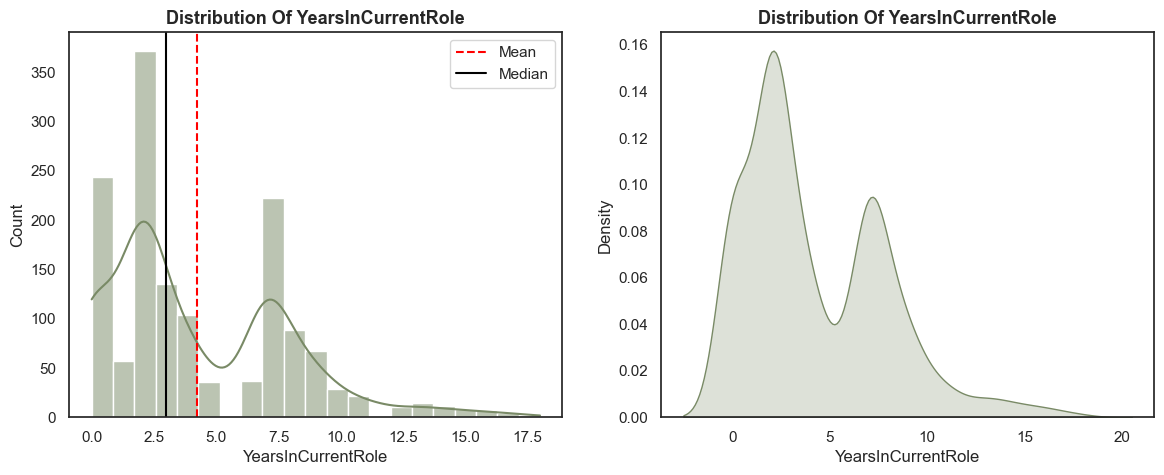

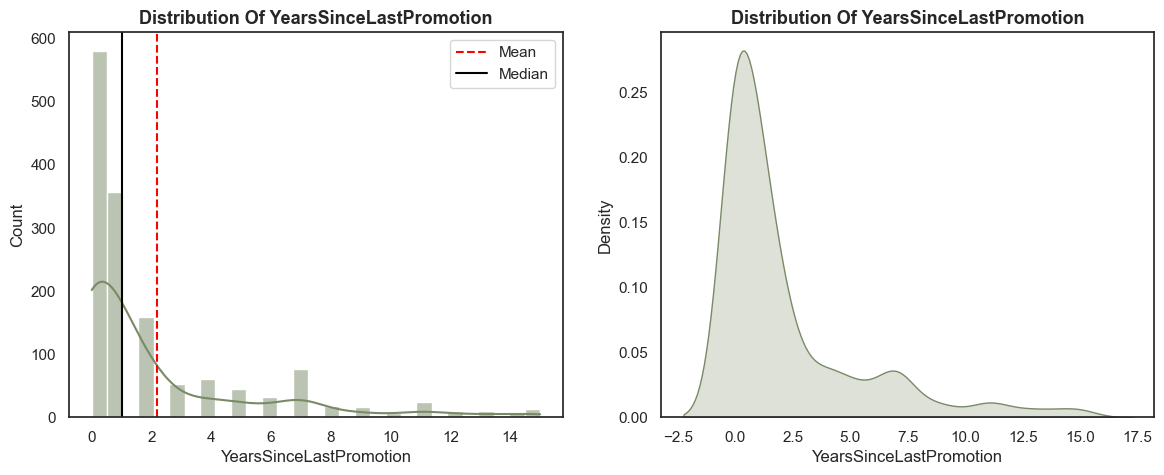

In [20]:
num_cols = df.select_dtypes(include='int') # Numerical features
for i in num_cols:
    plt.figure(figsize=(14,5))
    plt.subplot(121)
    sns.histplot(df[i], kde=True, color='#798A66')  
    plt.axvline(df[i].mean(), color='red', linestyle='--', label='Mean')  
    plt.axvline(df[i].median(), color='black', label='Median')  
    plt.legend()
    plt.title(f'Distribution Of {i}', fontsize=13, fontweight='bold')
    
    plt.subplot(122)
    sns.kdeplot(df[i], color='#798A66', fill=True)  
    plt.title(f'Distribution Of {i}', fontsize=13, fontweight='bold')
    plt.savefig('images/NumFeaturesDistribution.png')  
    plt.show()

### Interpretation 
The code generates paired plots (histogram with KDE overlay on left; filled KDE on right) for each integer-typed numerical feature in the dataset, highlighting distributions, means (red dashed), and medians (black). 

#### Common Distribution Patterns
- `Skewness & Central Tendency:` Right-skewed for continuous-like features (e.g., Age: peaks ~30-40, mean ~37 > median ~36; MonthlyIncome: long tail, mean ~$6,500 > median ~$4,900; TotalWorkingYears/YearsAtCompany: peaks early ~0-5 years, means pulled right by outliers). This indicates most employees are mid-career/mid-pay, with high earners/tenures rare—implying log transformations for modeling normality.
- `Discrete/Rating Features:` Multimodal or uniform (e.g., JobSatisfaction/EnvironmentSatisfaction 1-4: peaks at 3-4, near-uniform; PerformanceRating ~3-4: heavily skewed to high). Means ≈ medians (~2.7-3.5), showing positive bias in self-ratings.
- `Constants:` DistanceFromHome, NumCompaniesWorked: Right-skewed with early peaks (Distance ~1-10 miles; NumCompanies ~1-3), means > medians, highlighting commute/job-hopping variability.

### Implications
Plots confirm non-normal distributions (skew, multimodality), supporting nonlinear models (e.g., trees) over linear for attrition prediction. High early concentrations (e.g., short tenures) align with ~16% turnover risk; features like income/age show potential for segmentation in HR strategies to retain outliers.

In [21]:
import plotly.express as px
# Violin plot for distribution of TrainingTimesLastYear across Department, colored by Attrition for relevance to turnover
fig = px.violin(
    df,
    x='Department',
    y='TrainingTimesLastYear',
    color='Attrition',
    title='Distribution of Training Times Last Year Across Departments by Attrition',
    labels={'Attrition': 'Attrition Status'},
    color_discrete_map={'Yes': '#AD687B', 'No': '#798A66'}
)
fig.update_layout(
    xaxis_title='Department',
    yaxis_title='Training Times Last Year',
    legend_title='Attrition',
    hovermode='closest'
)
fig.show()
print("Training is skewed toward 2-3 sessions (median ~3), with most employees receiving moderate training regardless of department or attrition. Wider violin sections indicate higher density of employees at those training levels.")

Training is skewed toward 2-3 sessions (median ~3), with most employees receiving moderate training regardless of department or attrition. Wider violin sections indicate higher density of employees at those training levels.


## Understanding the Task

## EDA Summary and Next Steps

**Exploratory Data Analysis Findings** 
- EDA revealed a highly imbalanced dataset (1233 retained / 84% No, 237 attrited / 16% Yes), with no missing values or duplicates after cleaning.
- Outliers were capped in high-variance features like MonthlyIncome and YearsAtCompany to improve model robustness.
- Visualizations showed attrition linked to:
  - Younger age (mean 33.6 vs. 37.6)
  - Lower JobSatisfaction (median 2 vs. 3)
  - Lower income (mean $4,787 vs. $6,832)
  - Overtime (30% attrition rate vs. 10%)
  - Longer commutes (mean 10.6 vs. 8.9 miles)
  - Single marital status (~25% attrition)
  - Sales department (~25% attrition)
  - Roles like Sales Rep (~40% attrition) and Research Scientist (~20%).
- Correlation heatmap indicated multicollinearity among experience-related features (e.g., TotalWorkingYears and JobLevel ~0.78; YearsAtCompany and YearsInCurrentRole ~0.76), but weak direct ties to Attrition (e.g., Age ~-0.16, MonthlyIncome ~-0.16), suggesting nonlinear interactions captured better by tree-based models.

**Business Impact** 
With attrition costing 1.5–2x salary in replacement, targeting high-risk groups (e.g., young sales reps with long commutes and overtime) via surveys, pay raises, or remote work could reduce turnover by 10–20%.

**Initial Task**    
- **Step 1**: The target Attrition is imbalanced (84% No, 16% Yes), suggesting need for balancing in modeling (e.g., SMOTE or class weights).
- **Step 2**: Feature engineering: Bin Age into categories (e.g., <30, 30-40, >40); create Tenure Ratio (YearsAtCompany / (TotalWorkingYears + 1e-6) to avoid division-by-zero).
- **Step 3**: Encode categoricals for modeling (one-hot for nominal like Department, label for ordinal like Education).
- **Step 4**: Hypothesis Testing and Modeling



**Exploratory Data Analysis Finding** 
- EDA revealed a highly imbalanced dataset (84% retention, 16% attrition), with no missing values or duplicates.
- Outliers were capped in high-variance features like MonthlyIncome and YearsAtCompany to improve model robustness.
- Visualizations showed attrition linked to:
- - younger age (mean 33 vs. 37)
  - lower JobSatisfaction (median 2 vs. 3)
  - lower income ($5k vs. $6.5k)
  - overtime (30% attrition rate vs. 10%)
  - longer commutes (>10 miles)
  - single marital status
  - Sales department (~25% attrition)
  - roles like Research Scientist.
- Correlation heatmap indicated multicollinearity among experience-related features (e.g., TotalWorkingYears and JobLevel ~0.78), but weak direct ties to Attrition, suggesting nonlinear interactions captured better by models.

**Business Impact** 
With attrition costing 1.5–2x salary in replacement, targeting high-risk groups (e.g., young sales reps with long commutes) via surveys, pay raises, or remote work could reduce turnover by 10–20%.

**Initial Task**    
- **Step 1**: The target Attrition is imbalanced (84% No, 16% Yes), suggesting need for balancing in modeling.
- **Step 2**: Feature engineering: Bin Age into categories, create Tenure Ratio (YearsAtCompany / TotalWorkingYears)
- **Step 3**: Encode categoricals for modeling (one-hot for nominal, label for ordinal if any)
- **Step 4**: Modeling